# Wielkoskalowe metody pomiarowe w biologii molekularnej
## Metody selekcji cech - 2. Selekcja genów lub białek o ekspresji różnicującej dwie grupy próbek przy użyciu metody Recursive Feature Elimination
### Bartosz Sowul, Katarzyna Szmulewicz

## test: instalacja potrzebnych modułów

In [1]:
%matplotlib inline
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit_learn

## test: ładowanie potrzebnych modułów

In [2]:
import pandas as pd

## Funkcja pomocnicza przygotowująca dane
### zbudowana na podstawie analizy wstępnej zbioru przeprowadzonej w analiza_wstepna.ipynb

In [40]:
def prepare_data(dataset, verbose=False):
    df = pd.read_csv(dataset, sep='\t')
    df = df.transpose()
    features = {key:value for key,value in enumerate(list(df.iloc[0, 1:]))}

    # df.rename(columns={0: 'class'}, inplace=True) # zmienia nazwę 1 kolumny na class
    # dlaczego tak nie można?
    # okazuje się, że przy zamianie nazwy kolumny z indeksu na stringa i dropnięciu tej kolumny za pomocą difference([indeks])
    # kolumna 0 rzeczywiście znika
    # ale kolumna class jest przenoszona na koniec dataframe'a
    # czyli w zbiorze uczącym zostaje cheat feature oznaczająca klasę O.O
    # wszędzie gdzie jest df1[0] było df1['class']
    df1 = df.iloc[1:] # bez nazw kolumn
    #print(df.iloc[0:])

    class_num  = int(df1[0].describe()['unique'])
    
    if verbose:
        print(df1[0].describe())
        print(class_num)
    
    while class_num > 2:
        counts = df1[0].value_counts()
        
        if verbose:
            print(f'class_num: {class_num}')
            print(f'counts:\n{counts}')
            print(f'counts.idx: {counts.idxmin()}')
            print(f'counts[counts.idxmin()]:\n{counts[counts.idxmin()]}')
            print(f'counts[counts > min(counts)]:\n{counts[counts > min(counts)]}')
            print()
        
        df1 = df1[df1[0] != counts.idxmin()]
        class_num -= 1
    else:
        if verbose:
            print(f'ZOSTAŁY 2 KLASY:')
            print(f'class_num: {class_num}')
            print('counts:\n{}'.format(df1['class'].value_counts()))
            print(df1.shape)
            print(df1.isnull().values.any()) # sprawdza, czy dane są kompletne
            
        df1 = df1.apply(pd.to_numeric) # zmienia typy ze stringów na liczby
        X = df1[df1.columns.difference([0])]
        y = df1.iloc[:, 0]

        return X.values, y.values, features

## Ładowanie danych

In [41]:
DATA_PATH = './data'
DIRS = ['Leukemia', 'LungCancer', 'Lymphoma']
datasets_preprocessed = [d+'_preprocessed.txt' for d in DIRS]
datasets_500 = [d+'_500.txt' for d in DIRS]
datasets_preprocessed_paths = []
datasets_500_paths = []

print('Preparing datasets paths:')
for dataset_preprocessed, dataset_500, directory in zip(datasets_preprocessed, datasets_500, DIRS):
    datasets_preprocessed_paths.append(DATA_PATH + '/' + directory + '/' + dataset_preprocessed)
    datasets_500_paths.append(DATA_PATH + '/' + directory + '/' + dataset_500)
    print('\t- ',dataset_preprocessed,'->',datasets_preprocessed_paths[-1])
    print('\t- ',dataset_500,'->',datasets_500_paths[-1])
else:
    print('Paths created.\n')

XX = []
yy = []
features = []

for dataset_preprocessed_path, dataset_500_path in zip(datasets_preprocessed_paths, datasets_500_paths):
    print(f'Preparing {dataset_preprocessed_path}...')
    X, y, f = prepare_data(dataset_preprocessed_path)
    XX.append(X)
    yy.append(y)
    features.append(f)
    print(f'Preparing {dataset_500_path}...')
    X, y, f = prepare_data(dataset_500_path)
    XX.append(X)
    yy.append(y)
    features.append(f)
    print('Done.')
    print()
else:
    print('All datasets ready.')

Preparing datasets paths:
	-  Leukemia_preprocessed.txt -> ./data/Leukemia/Leukemia_preprocessed.txt
	-  Leukemia_500.txt -> ./data/Leukemia/Leukemia_500.txt
	-  LungCancer_preprocessed.txt -> ./data/LungCancer/LungCancer_preprocessed.txt
	-  LungCancer_500.txt -> ./data/LungCancer/LungCancer_500.txt
	-  Lymphoma_preprocessed.txt -> ./data/Lymphoma/Lymphoma_preprocessed.txt
	-  Lymphoma_500.txt -> ./data/Lymphoma/Lymphoma_500.txt
Paths created.

Preparing ./data/Leukemia/Leukemia_preprocessed.txt...
Preparing ./data/Leukemia/Leukemia_500.txt...
Done.

Preparing ./data/LungCancer/LungCancer_preprocessed.txt...
Preparing ./data/LungCancer/LungCancer_500.txt...
Done.

Preparing ./data/Lymphoma/Lymphoma_preprocessed.txt...
Preparing ./data/Lymphoma/Lymphoma_500.txt...
Done.

All datasets ready.


## Implementacja funkcji Recursive Feature Elimination

In [5]:
from math import floor
from time import time

import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(floor(n/10)%10!=1)*(n%10<4)*n%10::4])

def recursive_feature_elimination(X, y, verbose=0):
    
    n_features = X.shape[1]
    features_left = X.shape[1]
    features_eliminated = []
    cv_results = []
    
    ranking_dict = {i: 1 for i in range(n_features)}
    remaining = [True for i in range(n_features)]
    features = np.arange(n_features)[remaining]
    i = 0
    
    start = time()
    
    while features_left > 1:
        # Remaining features
        # array (0, n_features) with boolean masking
        # https://docs.scipy.org/doc/numpy-1.15.0/user/basics.indexing.html#boolean-or-mask-index-arrays
        features = np.arange(n_features)[remaining]
        
        # Create SVM model using a linear kernel
        clf = SVC(kernel='linear', gamma='auto')
        
        if verbose >= 0:
            print(f'Fitting classifier with {features_left} features.')
        else:
            pass

        clf.fit(X[:, features], y)
        # Get cv score on remaining features
        cv_results.append(cross_val_score(clf, X[:, features], y,
                            scoring='accuracy', cv=StratifiedKFold(2), n_jobs=1).mean())

        # Calc ranks
        ranks = clf.coef_ ** 2
        # Rank the remaining features
        ranks = np.argsort(ranks.sum(axis=0))
        # argsort sorts asc, sum over columns
        # axis 0: the first running vertically downwards across rows,
        # axis 1: the second running horizontally across columns.
        # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.argsort.html
        
        features_eliminated.append(features[ranks][0])
        ranking_dict[features[ranks][0]] = features_left

        # Eliminate the worst feature
        remaining[features[ranks][0]] = False
        features_left -= 1
        i += 1
        
        if verbose > 0:
            print('features ranked from worst to best:\n', ranks)
            print(f'worst feature at {ordinal(i)} iter:\n', features[ranks][0])
            print('features eliminated so far:\n', features_eliminated)
            print('features left:\n', np.arange(n_features)[remaining])
            print('ranking:\n', ranking_dict)
            if verbose == 2:
                input('Press Enter to continue....\n')
    else:
        final_ranking = list(ranking_dict.items())
        if sum(range(1, n_features+1)) == sum(rank for feature, rank in final_ranking):
            if verbose > 0:
                print(f'\nRFECV took {time() - start:.2f} seconds.')
                print('\nfinal ranking:\n', final_ranking)
                print('\nranking:\n', ranking_dict)
            return final_ranking, ranking_dict, list(reversed(cv_results))
        else:
            print("Something's wrong...")

## test: recursive_feature_elimination na zbiorze digits

In [6]:
from operator import itemgetter

from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

final_ranking, ranking_dict, cv_results = recursive_feature_elimination(X, y, verbose=0)

# best is 30, worst is 0
print()
print(f'cv_results (from using 1 feature to using all of them):\n{cv_results}')
print()
print(f'ranking_sorted (from best to worst):\n{sorted(final_ranking, key=itemgetter(1))}')

Fitting classifier with 64 features.
Fitting classifier with 63 features.
Fitting classifier with 62 features.
Fitting classifier with 61 features.
Fitting classifier with 60 features.
Fitting classifier with 59 features.
Fitting classifier with 58 features.
Fitting classifier with 57 features.
Fitting classifier with 56 features.
Fitting classifier with 55 features.
Fitting classifier with 54 features.
Fitting classifier with 53 features.
Fitting classifier with 52 features.
Fitting classifier with 51 features.
Fitting classifier with 50 features.
Fitting classifier with 49 features.
Fitting classifier with 48 features.
Fitting classifier with 47 features.
Fitting classifier with 46 features.
Fitting classifier with 45 features.
Fitting classifier with 44 features.
Fitting classifier with 43 features.
Fitting classifier with 42 features.
Fitting classifier with 41 features.
Fitting classifier with 40 features.
Fitting classifier with 39 features.
Fitting classifier with 38 features.
F

## Funkcja pomocnicza do robienia wykresów

In [7]:
import matplotlib.pyplot as plt

def plot(cv_results, cutoff=-1, figsize=[20, 10]):
    plt.rcParams['figure.figsize'] = figsize
    plt.figure()
    plt.xlabel('Liczba wybranych cech')
    plt.ylabel('Średnia wartość metryki accuracy dla 2-Fold CV')
    if cutoff > 0:
        cutoff = int(cutoff)
        plt.plot(range(1, len(cv_results[:cutoff+1]) + 1), cv_results[:cutoff+1])
        print(f'Accuracy using {cutoff} features is {cv_results[cutoff]}.')
    else:
        plt.plot(range(1, len(cv_results) + 1), cv_results)
        index, value = max(enumerate(cv_results), key=itemgetter(1))
        print(f'Best accuracy is {value} using {index+1} features.')
    plt.show()

## test: robienie wykresów do wyników rfe na zbiorze digits

Best accuracy is 0.9438211015538291 using 31 features.


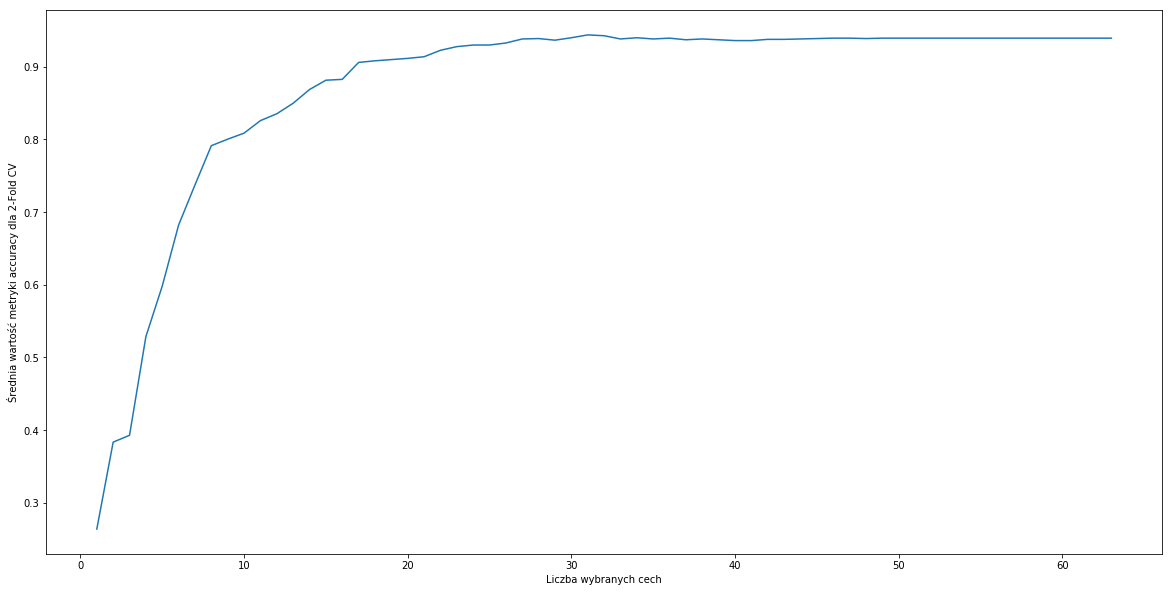

Accuracy using 25 features is 0.9326758710559695.


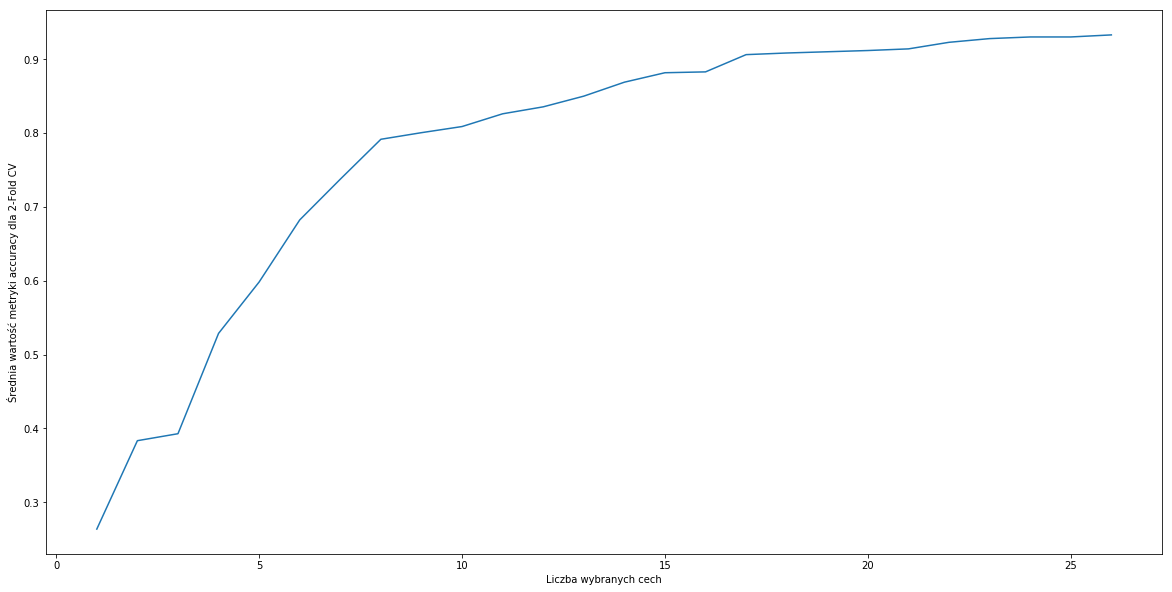

In [8]:
plot(cv_results)    
plot(cv_results, cutoff=25)

## Eksperymenty na wybranych zbiorach

In [9]:
print(f'DATA_PATH:\n\t{DATA_PATH}')
print(f'DIRS:\n\t{DIRS}')
print(f'datasets_preprocessed:\n\t{datasets_preprocessed}')
print(f'datasets_500:\n\t{datasets_500}')
print(f'datasets_preprocessed_paths:\n\t{datasets_preprocessed_paths}')
print(f'datasets_500_paths:\n\t{datasets_500_paths}')

DATA_PATH:
	./data
DIRS:
	['Leukemia', 'LungCancer', 'Lymphoma']
datasets_preprocessed:
	['Leukemia_preprocessed.txt', 'LungCancer_preprocessed.txt', 'Lymphoma_preprocessed.txt']
datasets_500:
	['Leukemia_500.txt', 'LungCancer_500.txt', 'Lymphoma_500.txt']
datasets_preprocessed_paths:
	['./data/Leukemia/Leukemia_preprocessed.txt', './data/LungCancer/LungCancer_preprocessed.txt', './data/Lymphoma/Lymphoma_preprocessed.txt']
datasets_500_paths:
	['./data/Leukemia/Leukemia_500.txt', './data/LungCancer/LungCancer_500.txt', './data/Lymphoma/Lymphoma_500.txt']


In [10]:
import itertools

datasets = list(itertools.chain.from_iterable(zip(datasets_preprocessed_paths, datasets_500_paths)))
results = {}

for dataset, X, y in zip(datasets, XX, yy):
    dataset = dataset.split('/')[-1].split('.')[0]
    print(f'dataset: {dataset}')
    final_ranking, ranking_dict, cv_results = recursive_feature_elimination(X, y, verbose=0)
    results[dataset] = {'final_ranking': final_ranking, 'ranking_dict': ranking_dict, 'cv_results': cv_results}
else:
    print('Done.')

dataset: Leukemia_preprocessed
Fitting classifier with 4116 features.
Fitting classifier with 4115 features.
Fitting classifier with 4114 features.
Fitting classifier with 4113 features.
Fitting classifier with 4112 features.
Fitting classifier with 4111 features.
Fitting classifier with 4110 features.
Fitting classifier with 4109 features.
Fitting classifier with 4108 features.
Fitting classifier with 4107 features.
Fitting classifier with 4106 features.
Fitting classifier with 4105 features.
Fitting classifier with 4104 features.
Fitting classifier with 4103 features.
Fitting classifier with 4102 features.
Fitting classifier with 4101 features.
Fitting classifier with 4100 features.
Fitting classifier with 4099 features.
Fitting classifier with 4098 features.
Fitting classifier with 4097 features.
Fitting classifier with 4096 features.
Fitting classifier with 4095 features.
Fitting classifier with 4094 features.
Fitting classifier with 4093 features.
Fitting classifier with 4092 feat

## Wyświetlenie kluczy przed obróbką wyników

In [11]:
print(results.keys())
print(results[list(results.keys())[0]].keys())

dict_keys(['Leukemia_preprocessed', 'Leukemia_500', 'LungCancer_preprocessed', 'LungCancer_500', 'Lymphoma_preprocessed', 'Lymphoma_500'])
dict_keys(['final_ranking', 'ranking_dict', 'cv_results'])


Leukemia_preprocessed
Best accuracy is 1.0 using 3 features.


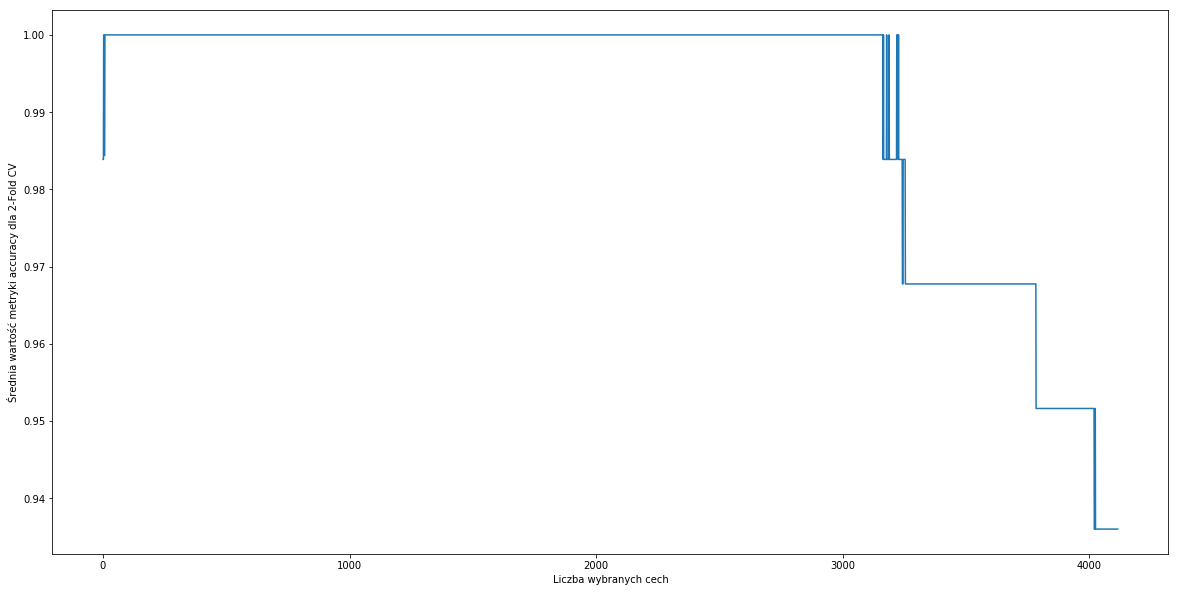

Leukemia_500
Best accuracy is 1.0 using 7 features.


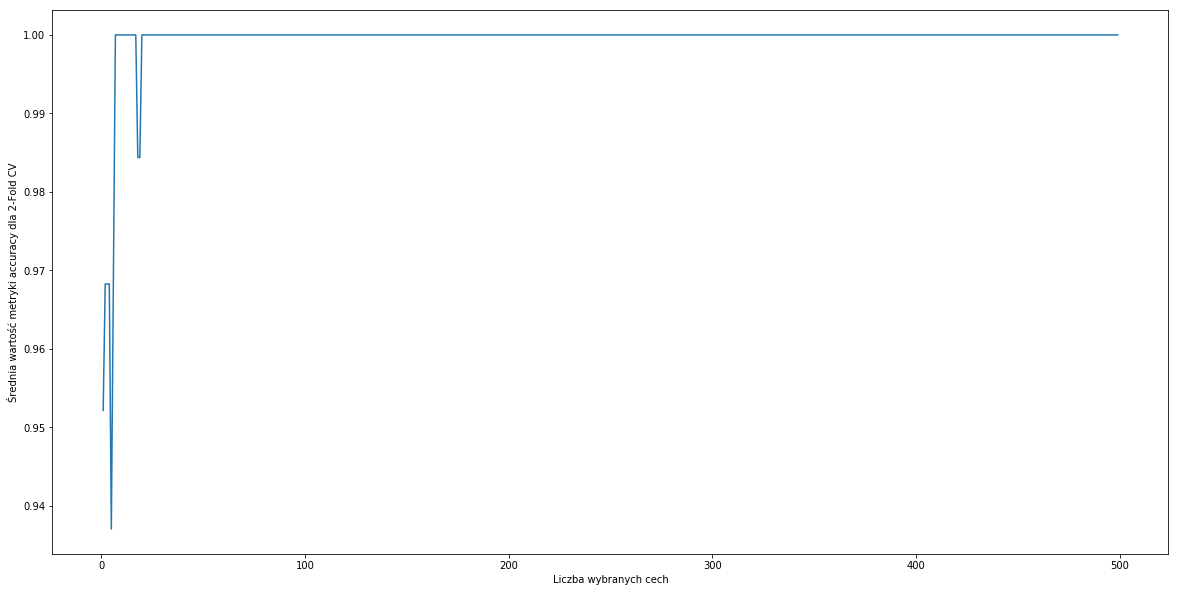

LungCancer_preprocessed
Best accuracy is 1.0 using 6 features.


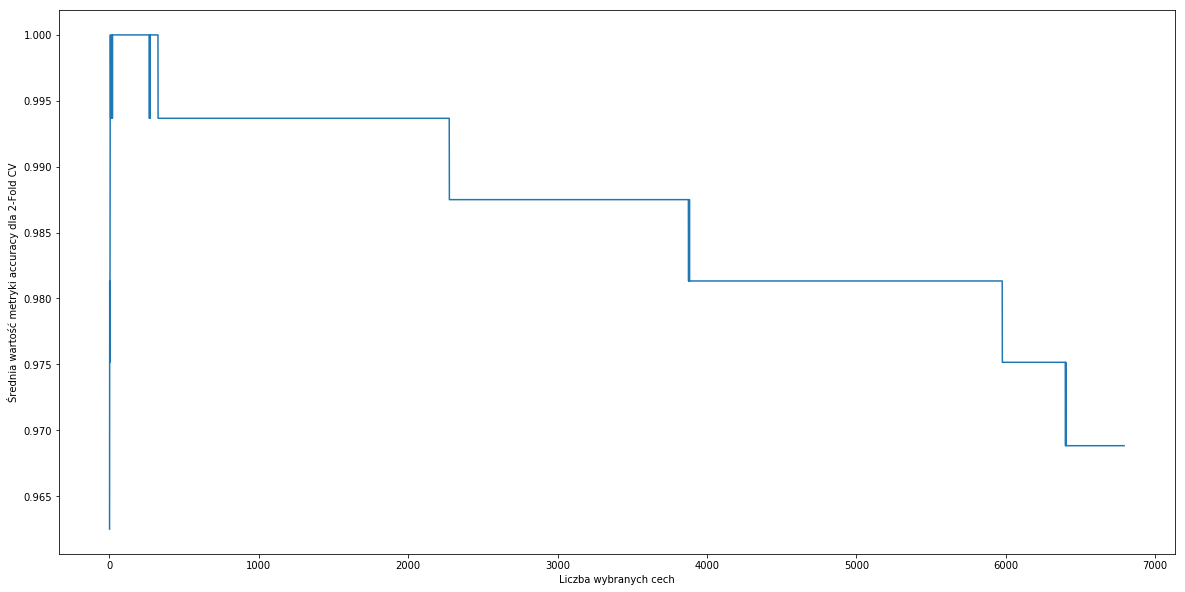

LungCancer_500
Best accuracy is 1.0 using 16 features.


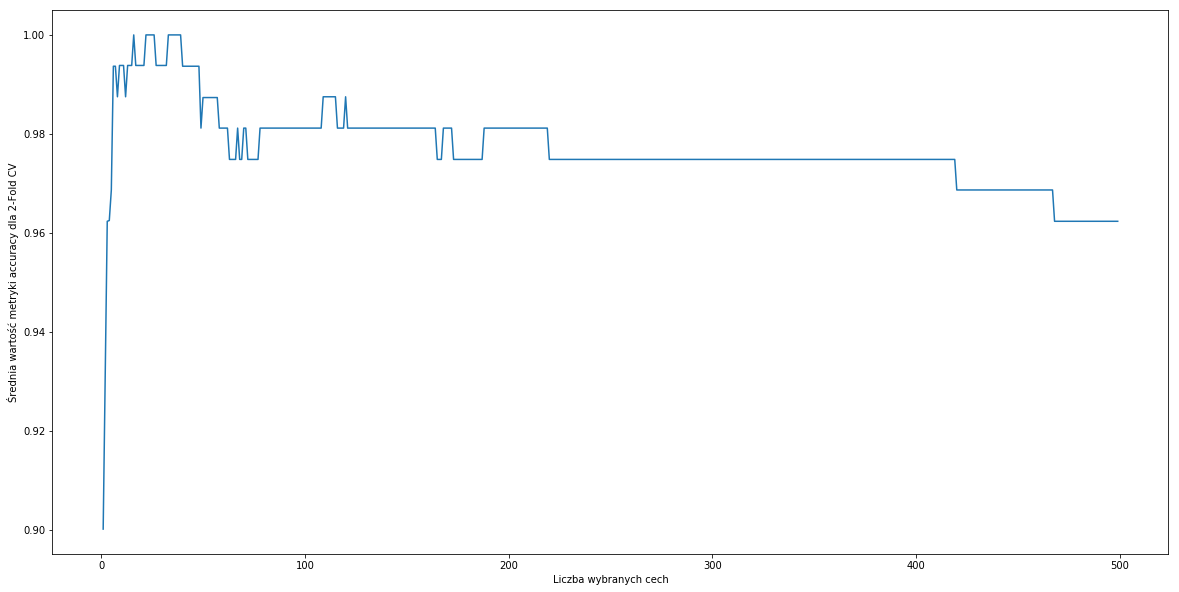

Lymphoma_preprocessed
Best accuracy is 1.0 using 1 features.


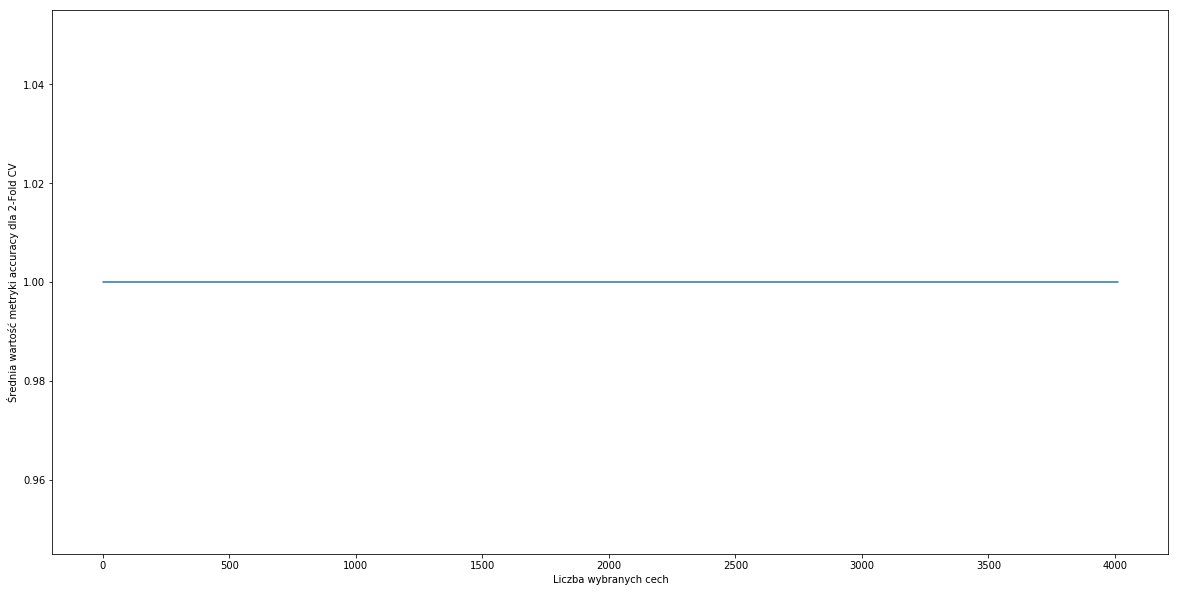

Lymphoma_500
Best accuracy is 1.0 using 1 features.


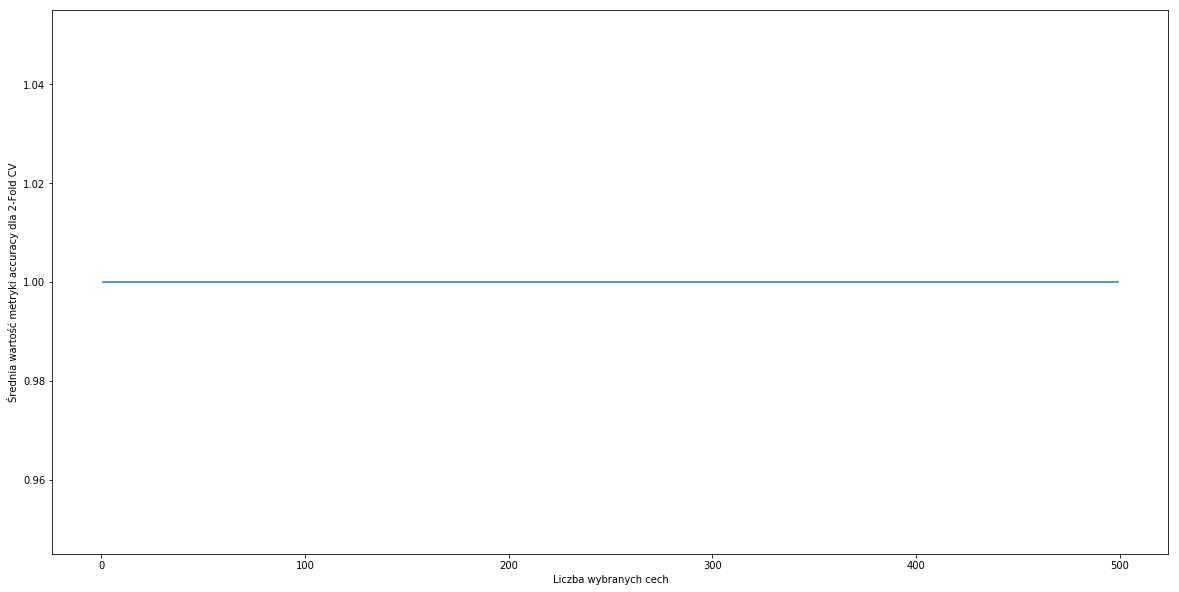

In [12]:
keys = list(results.keys())

for key in keys:
    print(key)
    plot(results[key]['cv_results'])

['Leukemia_preprocessed', 'Leukemia_500', 'LungCancer_preprocessed', 'LungCancer_500', 'Lymphoma_preprocessed', 'Lymphoma_500']
Leukemia_preprocessed
Accuracy using 500 features is 1.0.


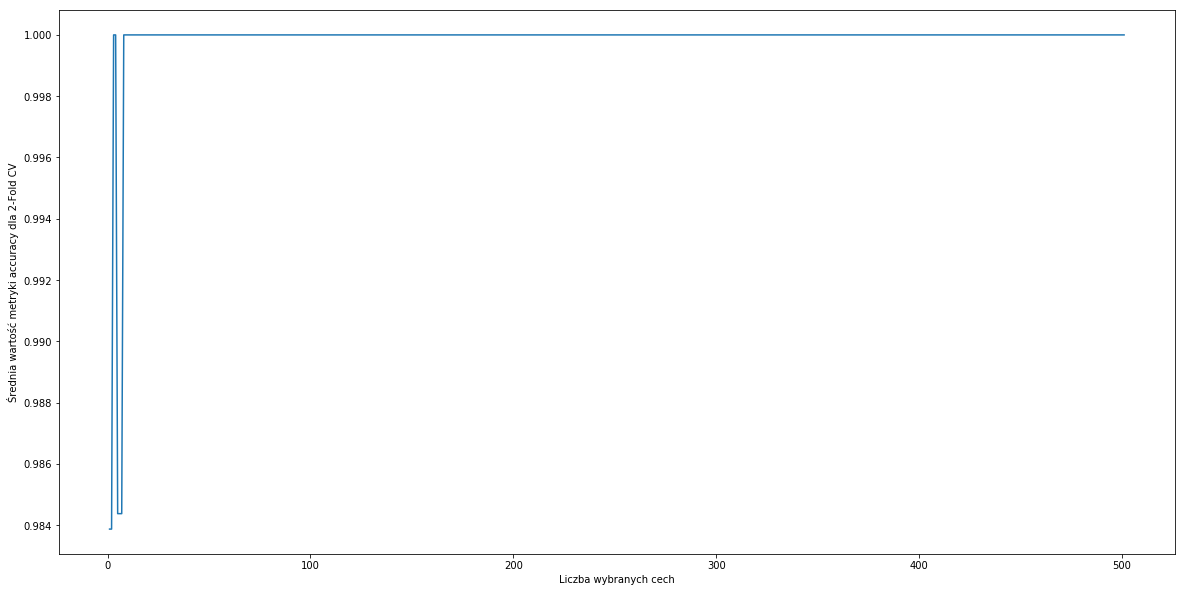

LungCancer_preprocessed
Accuracy using 500 features is 0.9936708860759493.


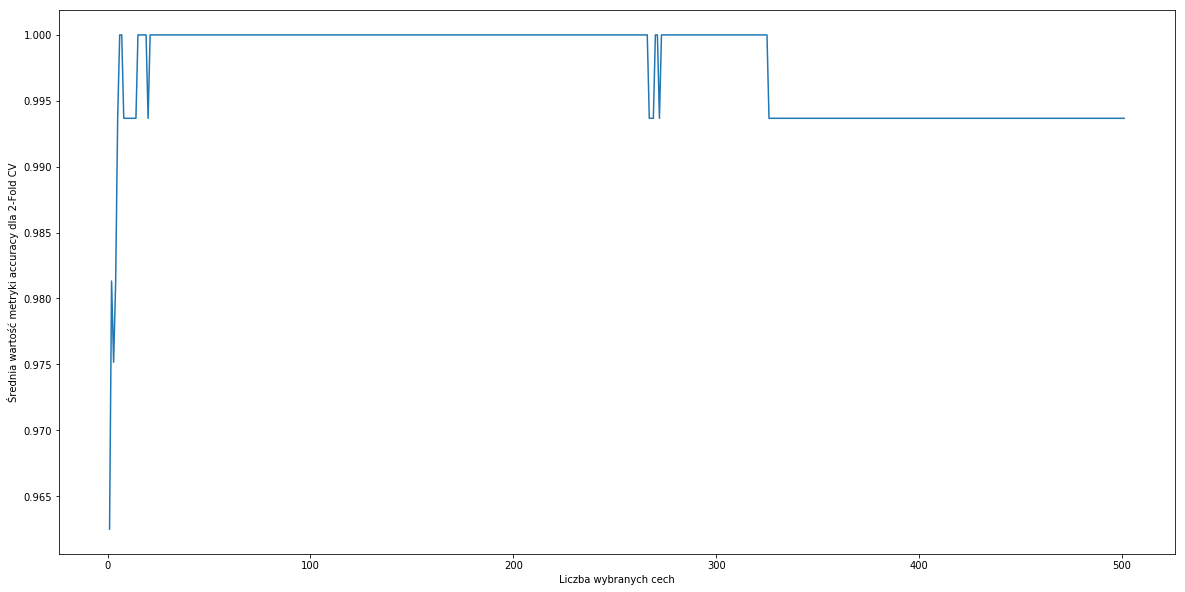

Lymphoma_preprocessed
Accuracy using 500 features is 1.0.


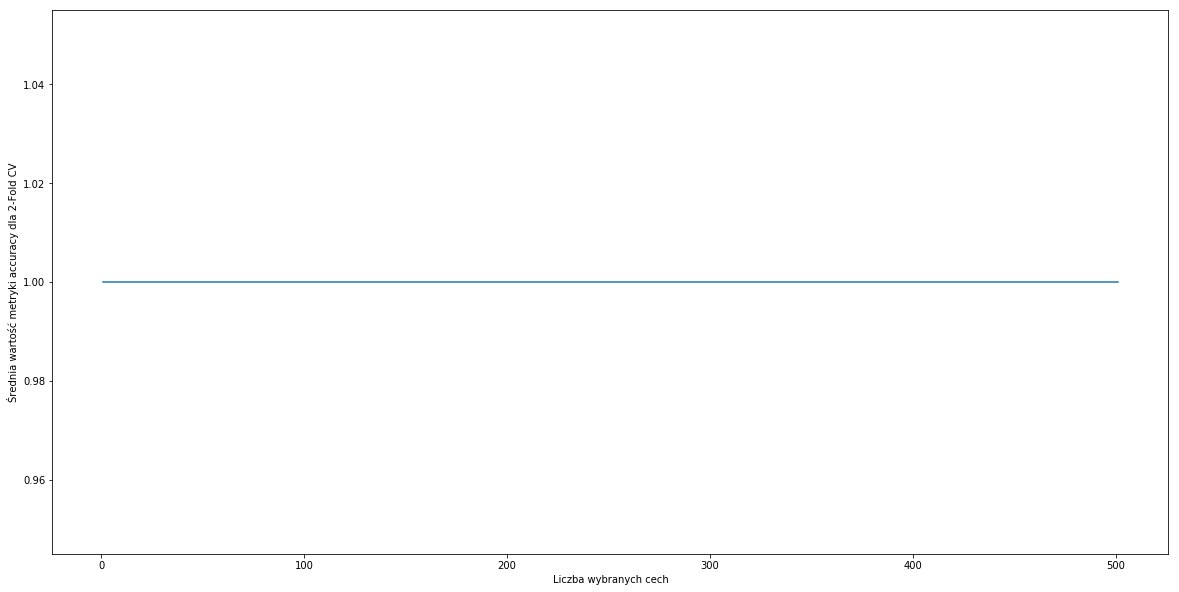

In [59]:
print(keys)
print('Leukemia_preprocessed')
plot(results['Leukemia_preprocessed']['cv_results'], cutoff=500)
print('LungCancer_preprocessed')
plot(results['LungCancer_preprocessed']['cv_results'], cutoff=500)
print('Lymphoma_preprocessed')
plot(results['Lymphoma_preprocessed']['cv_results'], cutoff=500)

In [75]:
print('Accuracy dla 500 cech:')
print(f"Leukemia_pre: {results['Leukemia_preprocessed']['cv_results'][500]}")
print(f"Leukemia_500: {results['Leukemia_500']['cv_results'][-1]}")
print(f"LungCancer_pre: {results['LungCancer_preprocessed']['cv_results'][500]}")
print(f"LungCancer_500: {results['LungCancer_500']['cv_results'][-1]}")
print(f"Lymphoma_pre: {results['Lymphoma_preprocessed']['cv_results'][500]}")
print(f"Lymphoma_500: {results['Lymphoma_500']['cv_results'][-1]}")

Accuracy dla 500 cech:
Leukemia_pre: 1.0
Leukemia_500: 1.0
LungCancer_pre: 0.9936708860759493
LungCancer_500: 0.9623378652914518
Lymphoma_pre: 1.0
Lymphoma_500: 1.0


Leukemia_preprocessed
Accuracy using 20 features is 1.0.


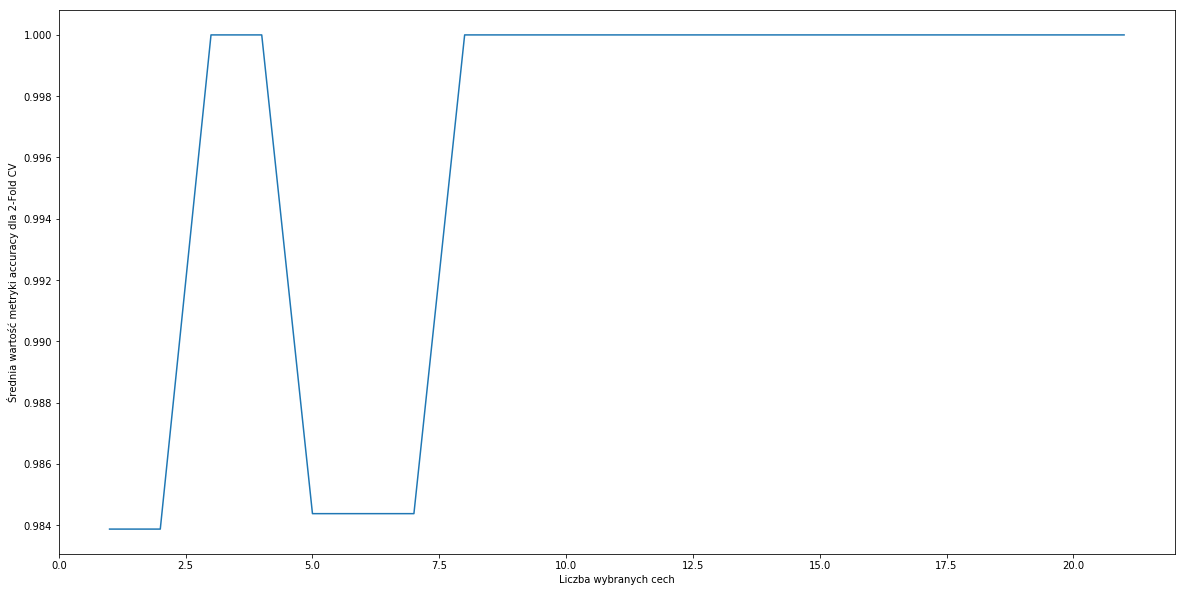

Leukemia_500
Accuracy using 20 features is 1.0.


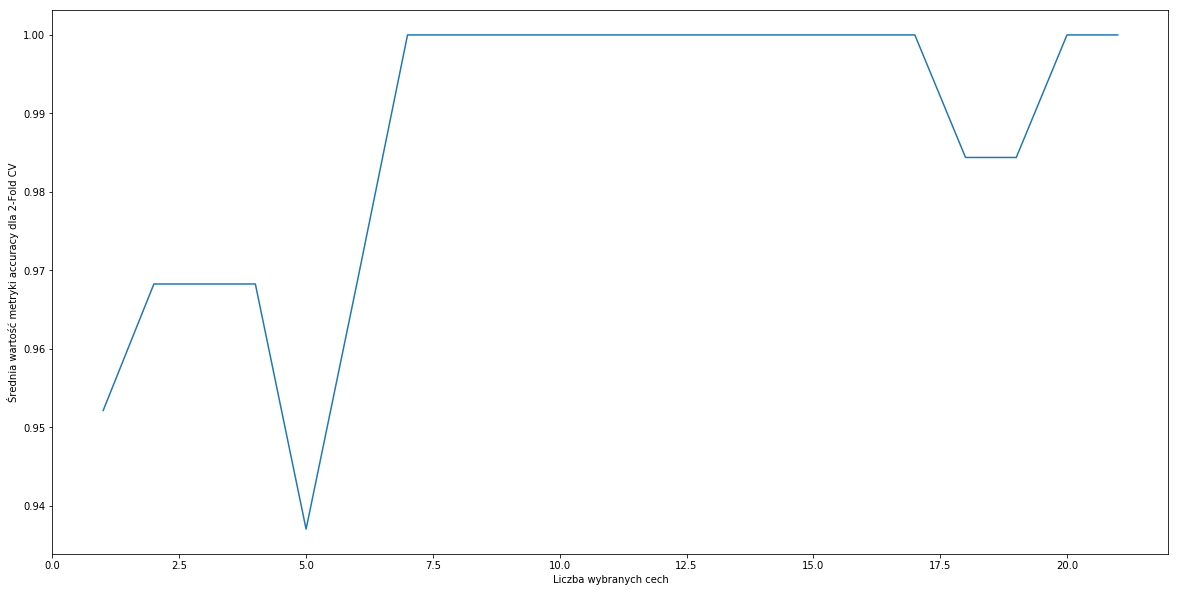

LungCancer_preprocessed
Accuracy using 20 features is 1.0.


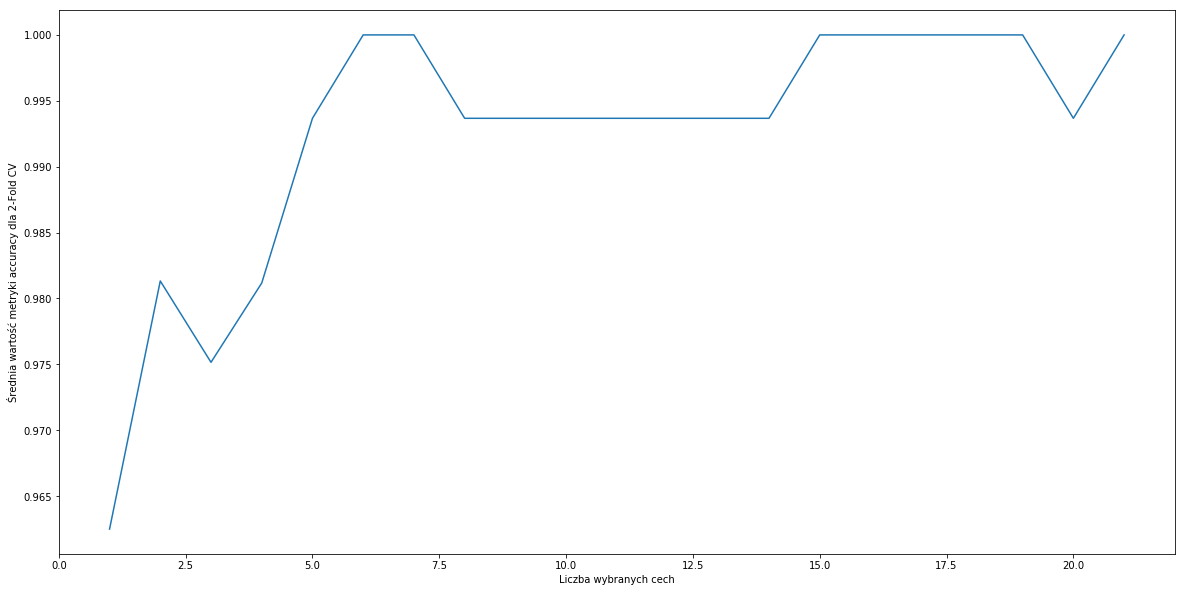

LungCancer_500
Accuracy using 20 features is 0.9938271604938271.


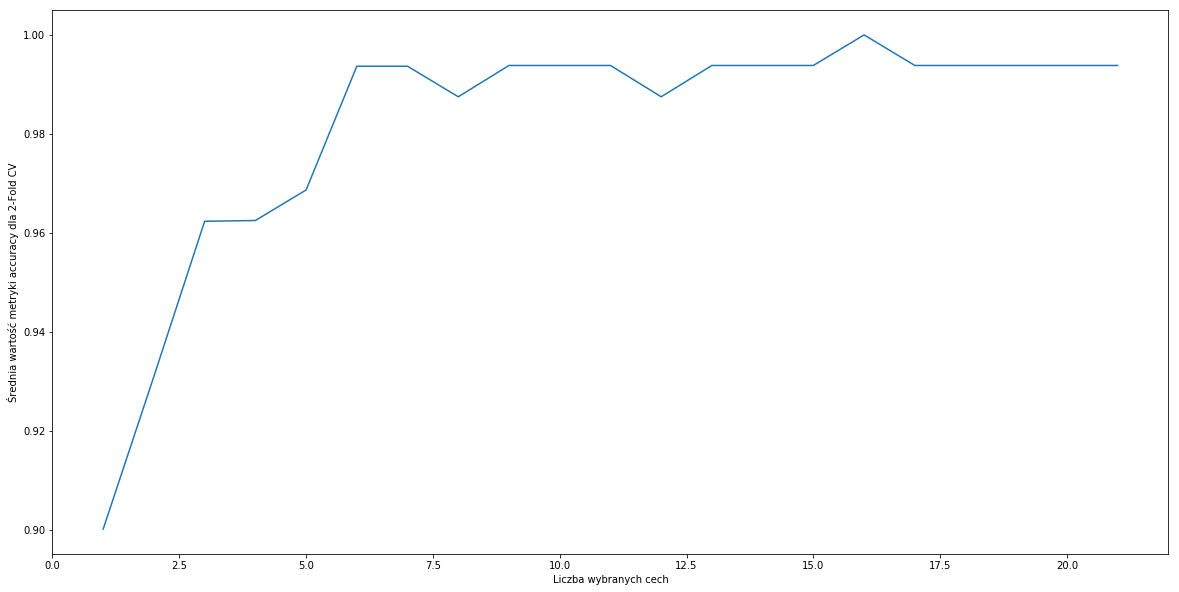

Lymphoma_preprocessed
Accuracy using 20 features is 1.0.


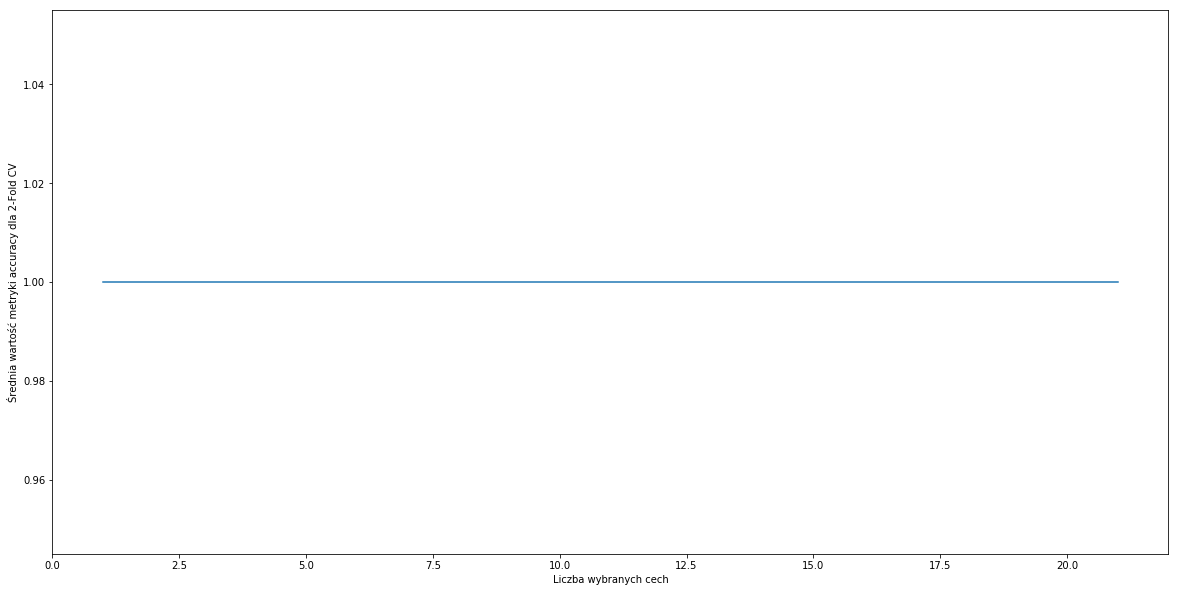

Lymphoma_500
Accuracy using 20 features is 1.0.


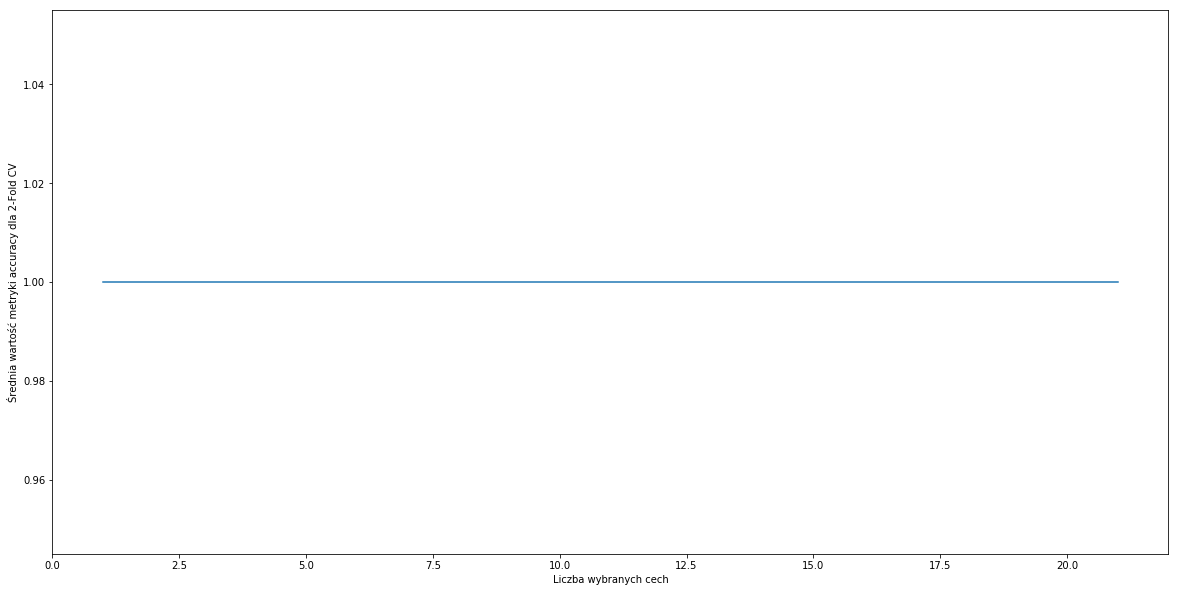

In [76]:
for key in keys:
    print(key)
    plot(results[key]['cv_results'], cutoff=20)

## Porównanie zbiorów

In [110]:
def compare_sets(ranking, num, dataset1_id, dataset2_id, keys=keys, features=features):
    print(keys[dataset1_id])
    print(keys[dataset2_id])
    
    ranking1 = sorted(results[keys[dataset1_id]]['final_ranking'], key=itemgetter(1))
    ranking2 = sorted(results[keys[dataset2_id]]['final_ranking'], key=itemgetter(1))
    ranking1_sub = ranking1[:num]
    ranking2_sub = ranking2[:num]
    ranking1_sub_d = [features[dataset1_id][f[0]] for f in ranking1_sub]
    ranking2_sub_d = [features[dataset2_id][f[0]] for f in ranking2_sub]
    
    setA = set(ranking1_sub_d)
    setB = set(ranking2_sub_d)

    overlap = setA & setB
    union = setA | setB

    result1 = float(len(overlap)) / len(setA) * 100
    result2 = float(len(overlap)) / len(union) * 100
    print(f'{result1:.4}')
    print(f'{result2:.4}')
    print()

print('500 cech:')
compare_sets(results, num=500, dataset1_id=0, dataset2_id=1)
compare_sets(results, num=500, dataset1_id=2, dataset2_id=3)
compare_sets(results, num=500, dataset1_id=4, dataset2_id=5)
print('20 cech:')
compare_sets(results, num=20, dataset1_id=0, dataset2_id=1)
compare_sets(results, num=20, dataset1_id=2, dataset2_id=3)
compare_sets(results, num=20, dataset1_id=4, dataset2_id=5)
print('5 cech:')
compare_sets(results, num=5, dataset1_id=0, dataset2_id=1)
compare_sets(results, num=5, dataset1_id=2, dataset2_id=3)
compare_sets(results, num=5, dataset1_id=4, dataset2_id=5)

500 cech:
Leukemia_preprocessed
Leukemia_500
48.2
31.75

LungCancer_preprocessed
LungCancer_500
10.8
5.708

Lymphoma_preprocessed
Lymphoma_500
44.83
28.86

20 cech:
Leukemia_preprocessed
Leukemia_500
65.0
48.15

LungCancer_preprocessed
LungCancer_500
15.0
8.108

Lymphoma_preprocessed
Lymphoma_500
63.16
48.0

5 cech:
Leukemia_preprocessed
Leukemia_500
20.0
11.11

LungCancer_preprocessed
LungCancer_500
0.0
0.0

Lymphoma_preprocessed
Lymphoma_500
80.0
66.67



In [54]:
def get_best_features(ranking, num, dataset_id, keys=keys, features=features):
    ranking = sorted(results[keys[dataset_id]]['final_ranking'], key=itemgetter(1))
    print(keys[dataset_id])
    for i in range(num):
        print(f'\tFeature {i+1}: {features[dataset_id][ranking[i][0]]}')
    else:
        print()

for dataset in range(len(datasets)):
    get_best_features(results, 10, dataset)

Leukemia_preprocessed
	Feature 1: M11722_at
	Feature 2: X95735_at
	Feature 3: U70063_at
	Feature 4: X59739_at
	Feature 5: M21535_at
	Feature 6: U05259_rna1_at
	Feature 7: X06948_at
	Feature 8: U72621_at
	Feature 9: M96326_rna1_at
	Feature 10: Y00787_s_at

Leukemia_500
	Feature 1: U70063_at
	Feature 2: M31166_at
	Feature 3: D88270_at
	Feature 4: L09209_s_at
	Feature 5: M96326_rna1_at
	Feature 6: U72621_at
	Feature 7: X06948_at
	Feature 8: M11722_at
	Feature 9: M28130_rna1_s_at
	Feature 10: M98399_s_at

LungCancer_preprocessed
	Feature 1: 33109_f_at
	Feature 2: 41449_at
	Feature 3: 38202_at
	Feature 4: 39240_at
	Feature 5: 1005_at
	Feature 6: 37332_r_at
	Feature 7: 41402_at
	Feature 8: 1385_at
	Feature 9: 39581_at
	Feature 10: 1507_s_at

LungCancer_500
	Feature 1: 34091_s_at
	Feature 2: 35999_r_at
	Feature 3: 40079_at
	Feature 4: 36040_at
	Feature 5: 37148_at
	Feature 6: 37345_at
	Feature 7: 35726_at
	Feature 8: 33218_at
	Feature 9: 36133_at
	Feature 10: 41424_at

Lymphoma_preprocessed
	

In [105]:
get_best_features(results, 3, 0)
get_best_features(results, 7, 1)
get_best_features(results, 6, 2)
get_best_features(results, 16, 3)
get_best_features(results, 1, 4)
get_best_features(results, 1, 5)

Leukemia_preprocessed
	Feature 1: M11722_at
	Feature 2: X95735_at
	Feature 3: U70063_at

Leukemia_500
	Feature 1: U70063_at
	Feature 2: M31166_at
	Feature 3: D88270_at
	Feature 4: L09209_s_at
	Feature 5: M96326_rna1_at
	Feature 6: U72621_at
	Feature 7: X06948_at

LungCancer_preprocessed
	Feature 1: 33109_f_at
	Feature 2: 41449_at
	Feature 3: 38202_at
	Feature 4: 39240_at
	Feature 5: 1005_at
	Feature 6: 37332_r_at

LungCancer_500
	Feature 1: 34091_s_at
	Feature 2: 35999_r_at
	Feature 3: 40079_at
	Feature 4: 36040_at
	Feature 5: 37148_at
	Feature 6: 37345_at
	Feature 7: 35726_at
	Feature 8: 33218_at
	Feature 9: 36133_at
	Feature 10: 41424_at
	Feature 11: 32138_at
	Feature 12: 33343_at
	Feature 13: 41385_at
	Feature 14: 41620_at
	Feature 15: 41691_at
	Feature 16: 34265_at

Lymphoma_preprocessed
	Feature 1: (Unknown; Clone=1352493)

Lymphoma_500
	Feature 1: (Unknown; Clone=1352493)

